# Etude des systèmes de recommandation - by Florent DE BORTOLI

Ce notebook a pour but de rassembler l'ensemble de mon travail sur mon projet d'étude des systèmes de recommandation, dans le cadre de mon projet de semestre à Eurecom (Sophia-Antipolis).

Les systèmes de recommandation sont devenus incontournables dans de nombreux domaines, avec des applications dans beaucoup des secteurs. Par exemple, ils sont très utilisés par les entreprises de commerce en ligne telles qu'Amazon pour recommander à leurs clients des articles qu'ils seraient susceptibles d'acheter. Les services de streaming video et audio tels que Netflix, Spotify et Deezer les utilisent pour suggerer à leur utiliseurs des playlists qu'ils pourraient aimer. Les systèmes de réservation et les compagnies aériennes les utilisent pour recommander à leurs clients des destinations qu'ils sont susceptibles de choisir pour leur prochains voyages. Apple et Google les utilisent également pour proposer des applications sur leur store aux utilisateurs en fonction de celles qu'ils ont déjà téléchargées, etc...

Les systèmes de recommandation font l'objet de nombreuses recherches actuellement. Il y a quelques années ils étaient encore relativement simples, aujourd'hui ils utilisent des techniques plus poussées d'Intelligence Artificielle et de Deep Learning avec des réseaux de neurones, ce qui permet de modéliser plus précisément les intéractions entre les utilisateurs et le contenu. On parlera alors d'users et d'items dans ce notebook afin de rendre les méthodes générales et applicables à de nombreux services, les items peuvent être aussi bien des articles sur un site de commerce en ligne, que des films sur Netflix ou des destinations de voyage d'une compagnie de transports.

Dans ce notebook, on présentera les différentes méthodes utilisées actuellement dans l'industrie, on parlera alors de la Matrix Factorization (MF), la MF généralisée (GMF), le perceptron multicouche (MLP) et enfin la combinaison de ces deux méthodes appelée Neural Matrix Factorization (NeuMF). Les méthodes seront bien sûr implémentées en Python, avec le framework Keras. On travaillera avec les deux datasets suivants:
- MovieLens : ce dataset contient les notes données par des utilisateurs à des films qu'ils ont regardés, on utilisera la version qui contient environ un million d'évaluations et où chaque utilisateur a noté au moins 20 films.
- Pinterest : ce dataset représente les interactions entre des utilisateurs et des images, il contient environ 1,5 million d'interactions et de même, on a retenu uniquement les utilisateurs qui ont au moins 20 interactions.

Ces deux datasets sont épars à 95% et même à 99% respectivement, ce qui est logique car chaque utilisateur a interagit avec un nombre très faible d'items en comparaison avec le nombre gigantesque d'items, ce qui modelise correctement la vie réelle.

## Importation des données et construction du dataset

On commence par importer toutes les bibliothèques nécessaires au traitement des données, on utilisera le framework Keras pour l'implémentation du modèle.

In [1]:
import numpy as np
import math
import pandas as pd
from ast import literal_eval as make_tuple
from time import time
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Multiply, Dot
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
import matplotlib.pyplot as plt

In [2]:
train_file_path_movielens = "Data/ml-1m.train.rating"
negative_file_path_movielens = "Data/ml-1m.test.negative"

train_file_path_pinterest = "Data/pinterest-20.train.rating"
negative_file_path_pinterest = "Data/pinterest-20.test.negative"

In [5]:
batch_size = 2**13 #(8192)
K = 10
epochs = 10

In [6]:
def number_users_and_items(path, sep='\t', title_columns=False):
    file = open(file=path, mode='r')
    num_users, num_items = 0, 0
    if title_columns:
        file.readline()
    for line in file.readlines():
        split_line = line.split(sep=sep)
        userID, itemID = int(split_line[0]), int(split_line[1])
        if userID > num_users:
            num_users = userID
        if itemID > num_items:
            num_items = itemID
    file.close()
    return num_users+1, num_items+1 # we add one to take into account userID 0 and itemID 0

In [7]:
def get_train_set(path, num_negative_instances, num_items):
    data = []
    file = open(file=path, mode='r')
    current_user = 0
    interactions_per_user = []
    for line in file:
        split_line = line.split('\t')[:-1]
        user, item = int(split_line[0]), int(split_line[1])
        if user == current_user:
            interactions_per_user.append(item)
            data.append([user, item, 1])
        else:
            num_interactions = len(interactions_per_user)
            for i in range(num_negative_instances * num_interactions):
                random_item = np.random.randint(num_items)
                while (random_item in interactions_per_user):
                    random_item = np.random.randint(num_items)
                data.append([current_user, random_item, 0])
            data.append([user, item, 1])
            current_user = user
            interactions_per_user = [item]
    num_interactions = len(interactions_per_user)
    for i in range(num_negative_instances * num_interactions):
        random_item = np.random.randint(num_items)
        while (random_item in interactions_per_user):
            random_item = np.random.randint(num_items)
        data.append([current_user, random_item, 0])
    file.close()
    return np.array(data)

def get_test_set(negative_filepath):
    test_set = []
    negative_file = open(file=negative_filepath, mode="r")
    for line in negative_file:
        split_line = line.split(sep="\t")
        (user, positive_item) = make_tuple(split_line[0])
        items = [positive_item]+[int(split_line[i]) for i in range(1,len(split_line))]
        test_set.append(items)
    negative_file.close()
    return np.array(test_set)

In [8]:
print("\n*** Preprocessing of data ***")

start = time()

num_users_movielens, num_items_movielens = number_users_and_items(path=train_file_path_movielens)
train_set_movielens = get_train_set(path=train_file_path_movielens, num_negative_instances=4, num_items=num_items_movielens)
test_set_movielens = get_test_set(negative_filepath=negative_file_path_movielens)
print("\nDataset MovieLens")
print("Number of users : {}".format(num_users_movielens))
print("Number of items : {}".format(num_items_movielens))
print("Number of training interactions : {}".format(len(train_set_movielens)))
train_features_movielens = [train_set_movielens[:,0], train_set_movielens[:,1]]
train_labels_movielens = train_set_movielens[:,2]

num_users_pinterest, num_items_pinterest = number_users_and_items(path=train_file_path_pinterest)
train_set_pinterest = get_train_set(path=train_file_path_pinterest, num_negative_instances=4, num_items=num_items_pinterest)
test_set_pinterest = get_test_set(negative_filepath=negative_file_path_pinterest)
print("\nDataset Pinterest")
print("Number of users : {}".format(num_users_pinterest))
print("Number of items : {}".format(num_items_pinterest))
print("Number of training interactions : {}".format(len(train_set_pinterest)))
train_features_pinterest = [train_set_pinterest[:,0], train_set_pinterest[:,1]]
train_labels_pinterest = train_set_pinterest[:,2]

run_time = time()-start
print("Running time : {:.0f} min {:.0f} sec".format(run_time//60, run_time%60))

print("\nDatasets loaded successfully !")


*** Preprocessing of data ***

Dataset MovieLens
Number of users : 6040
Number of items : 3706
Number of training interactions : 4970845

Dataset Pinterest
Number of users : 55187
Number of items : 9916
Number of training interactions : 7228110
Running time : 1 min 4 sec

Datasets loaded successfully !


## Définition des modèles avec Keras

### Modèle MF

In [9]:
def get_model_MF(num_users, num_items, factors=8):
    d = factors
    
    user_input_MF = Input(shape=(1,), dtype='int32', name='user_input_MLP')
    item_input_MF = Input(shape=(1,), dtype='int32', name='item_input_MLP')

    user_embedding_MF = Embedding(input_dim=num_users, output_dim=d, name='user_embedding_MLP')(user_input_MF)
    item_embedding_MF = Embedding(input_dim=num_items, output_dim=d, name='item_embedding_MLP')(item_input_MF)

    user_latent_MF = Flatten()(user_embedding_MF)
    item_latent_MF = Flatten()(item_embedding_MF)
    
    dot = Dot(axes=1)([user_latent_MF, item_latent_MF])

    MF = Model(inputs=[user_input_MF, item_input_MF], outputs=dot)
    MF.compile(optimizer=tf.train.AdamOptimizer(), loss=binary_crossentropy)
    #MF.compile(optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.01), loss=binary_crossentropy)
    return MF

MF = get_model_MF(num_users=num_users_movielens, num_items=num_items_movielens)
MF.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input_MLP (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input_MLP (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding_MLP (Embedding)  (None, 1, 8)         48320       user_input_MLP[0][0]             
__________________________________________________________________________________________________
item_embedding_MLP (Embedding)  (None, 1, 8)         29648       item_input

### Modèle MLP

Le perceptron multicouche (MLP) est le réseau de neurones le plus simple et le plus courant. Son architecture est constituée d'un empilement de couches de neurones. Dans le cadre des systèmes de recommandation, on envoie en entrée la concaténation des embeddings des users et des items.
Les embeddings permettent de transformer un vecteur binaire presque vide et immense en un vecteur beaucoup plus petit rempli par des nombres réels, de la même manière que pour traitement de texte dans le cadre du NLP et des algorithmes Word2Vec.

<img src="Pictures/schema_MLP.png" scale=0.5>

In [10]:
def get_model_MLP(num_users, num_items, layers=[32,16,8], d=16): #predictive factors = last hidden layer
    if len(layers)!=0: # the parameter d is only used if layers is the empty list (MLP-0)
        assert layers[0]%2==0
        d = int(layers[0]/2)
    user_input_MLP = Input(shape=(1,), dtype='int32', name='user_input_MLP')
    item_input_MLP = Input(shape=(1,), dtype='int32', name='item_input_MLP')
    user_embedding_MLP = Embedding(input_dim=num_users, output_dim=d, name='user_embedding_MLP')(user_input_MLP)
    item_embedding_MLP = Embedding(input_dim=num_items, output_dim=d, name='item_embedding_MLP')(item_input_MLP)
    user_latent_MLP = Flatten()(user_embedding_MLP)
    item_latent_MLP = Flatten()(item_embedding_MLP)
    concatenation = Concatenate()([user_latent_MLP, item_latent_MLP])
    output = concatenation
    for num_units in layers:
        layer = Dense(units=num_units, activation='relu', name='layer%d' %num_units)
        output = layer(output) # last output len = factors
    prediction_MLP = Dense(units=1, activation='sigmoid', name='prediction_MLP')(output)
    MLP = Model(inputs=[user_input_MLP, item_input_MLP], outputs=prediction_MLP)
    MLP.compile(optimizer=tf.train.AdamOptimizer(), loss=binary_crossentropy)
    return MLP

MLP_movielens = get_model_MLP(num_users=num_users_movielens, num_items=num_items_movielens)
MLP_movielens.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input_MLP (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input_MLP (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding_MLP (Embedding)  (None, 1, 16)        96640       user_input_MLP[0][0]             
______________________________________________________________________________

In [ ]:
def get_model_MLP2(num_users, num_items, num_layers=3, factors=8, d=16): #predictive factors = last hidden layer
    if len(layers)!=0: # the parameter d is only used if layers is the empty list (MLP-0)
        assert layers[0]%2==0
        d = int(layers[0]/2)
    user_input_MLP = Input(shape=(1,), dtype='int32', name='user_input_MLP')
    item_input_MLP = Input(shape=(1,), dtype='int32', name='item_input_MLP')
    user_embedding_MLP = Embedding(input_dim=num_users, output_dim=d, name='user_embedding_MLP')(user_input_MLP)
    item_embedding_MLP = Embedding(input_dim=num_items, output_dim=d, name='item_embedding_MLP')(item_input_MLP)
    user_latent_MLP = Flatten()(user_embedding_MLP)
    item_latent_MLP = Flatten()(item_embedding_MLP)
    concatenation = Concatenate()([user_latent_MLP, item_latent_MLP])
    output = concatenation
    for i in range(num_layers):
        layer = Dense(units=(2**i)*factors, activation='relu', name='layer%d' %i)
        output = layer(output)
    prediction_MLP = Dense(units=1, activation='sigmoid', name='prediction_MLP')(output)
    MLP = Model(inputs=[user_input_MLP, item_input_MLP], outputs=prediction_MLP)
    MLP.compile(optimizer=tf.train.AdamOptimizer(), loss=binary_crossentropy)
    return MLP

MLP_movielens = get_model_MLP(num_users=num_users_movielens, num_items=num_items_movielens)
MLP_movielens.summary()

### Modèle GMF

La GMF (Generalized Matrix Factorization) est une forme généralisée de la MF (Matrix Factorization) utilisée dans les premiers systèmes de recommandation. Il s'agit en fait d'un produit scalaire ponderé, où chaque produit des éléments de chaque embedding est multiplié par un poids avant d'être ajouté à la somme globale du produit scalaire. Les poids sont appris par optimisation, de la même manière que le MLP vu précédemment.
On peut d'ailleurs considerer cette méthode comme un cas particulier du perceptron multicouche (MLP), en prenant une seule couche cachée comme architecture et la fonction identité comme fonction d'activation on retrouve bien la GMF.

<img src="Pictures/formule_GMF.png">

In [11]:
## GMF model
def get_model_GMF(num_users, num_items, factors=32): # predictive factors = factors
    d=factors
    user_input_GMF = Input(shape=(1,), dtype='int32', name='user_input_GMF')
    item_input_GMF = Input(shape=(1,), dtype='int32', name='item_input_GMF')

    user_embedding_GMF = Embedding(input_dim=num_users, output_dim=d, name='user_embedding_GMF')
    item_embedding_GMF = Embedding(input_dim=num_items, output_dim=d, name='item_embedding_GMF')

    user_latent_GMF = Flatten()(user_embedding_GMF(user_input_GMF))
    item_latent_GMF = Flatten()(item_embedding_GMF(item_input_GMF))

    mul = Multiply()([user_latent_GMF, item_latent_GMF]) # len = factors

    prediction_GMF = Dense(units=1, activation='sigmoid', name='prediction')(mul)

    GMF = Model(inputs=[user_input_GMF, item_input_GMF], outputs=prediction_GMF)
    GMF.compile(optimizer=tf.train.AdamOptimizer(), loss=binary_crossentropy)
    return GMF

GMF_movielens = get_model_GMF(num_users=num_users_movielens, num_items=num_items_movielens)
GMF_movielens.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input_GMF (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input_GMF (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding_GMF (Embedding)  (None, 1, 32)        193280      user_input_GMF[0][0]             
__________________________________________________________________________________________________
item_embedding_GMF (Embedding)  (None, 1, 32)        118592      item_input_GMF[0][0]             
____________________________________________________________________________________________

### Modèle NeuMF

Le modèle NeuMF (Neural Matrix Factorization) consiste à combiner les deux méthodes précedentes afin de tirer parti à la fois de la complexité du MLP ainsi que la simplicité du GMF. Ce modèle commence alors par utiliser séparément la même architecture que la GMF et le MLP, puis à concatener les résultats de la dernière couche cachée des deux méthodes. On envoie enfin cette concaténation à un autre perceptron multicouche appelée NeuMF layer, celui-ci est généralement constitué d'une seule couche cachée.
Les deux méthodes utilisent des embeddings différents, ce qui permet d'utiliser des tailles différentes d'embeddings pour chaque méthode, et donc de les rendre complètement indépendantes durant l'entrainement.

<img src="Pictures/schema_NeuMF.png">

In [12]:
## NeuMF model
def get_model_NeuMF(num_users, num_items):
    d=32
    user_input = Input(shape=(1,), dtype='int32', name='user_input_NeuMF')
    item_input = Input(shape=(1,), dtype='int32', name='item_input_NeuMF')

    ## MLP part
    user_embedding_MLP = Embedding(input_dim=num_users, output_dim=d, name='user_embedding_MLP')(user_input)
    item_embedding_MLP = Embedding(input_dim=num_items, output_dim=d, name='item_embedding_MLP')(item_input)

    user_latent_MLP = Flatten()(user_embedding_MLP)
    item_latent_MLP = Flatten()(item_embedding_MLP)

    concatenation_embeddings = Concatenate()([user_latent_MLP, item_latent_MLP])

    layer1 = Dense(units=64, activation='relu', name='layer1')(concatenation_embeddings)
    layer2 = Dense(units=32, activation='relu', name='layer2')(layer1)
    layer3 = Dense(units=16, activation='relu', name='layer3') (layer2)
    layer4 = Dense(units=8, activation='relu', name='layer4') (layer3)

    ## GMF part
    user_embedding_GMF = Embedding(input_dim=num_users, output_dim=d, name='user_embedding_GMF')
    item_embedding_GMF = Embedding(input_dim=num_items, output_dim=d, name='item_embedding_GMF')

    user_latent_GMF = Flatten()(user_embedding_GMF(user_input))
    item_latent_GMF = Flatten()(item_embedding_GMF(item_input))

    mul = Multiply()([user_latent_GMF, item_latent_GMF])

    concatenation_of_models = Concatenate()([mul, layer4])
    prediction_NeuMF = Dense(units=1, activation='sigmoid', name='prediction')(concatenation_of_models)

    NeuMF = Model(inputs=[user_input, item_input], outputs=prediction_NeuMF)
    NeuMF.compile(optimizer=tf.train.AdamOptimizer(), loss=binary_crossentropy)
    return NeuMF

NeuMF_movielens = get_model_NeuMF(num_users=num_users_movielens, num_items=num_items_movielens)
NeuMF_movielens.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input_NeuMF (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input_NeuMF (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding_MLP (Embedding)  (None, 1, 32)        193280      user_input_NeuMF[0][0]           
__________________________________________________________________________________________________
item_embedding_MLP (Embedding)  (None, 1, 32)        118592      item_input_NeuMF[0][0]           
____________________________________________________________________________________________

In [13]:
def get_model_NeuMF2(num_users, num_items, layers=[32,16,8]): #predictives factors = 16 (2*last hidden layer)
    
    assert type(layers[0]%2==0)
    d = int(layers[0]/2)
    
    user_input = Input(shape=(1,), dtype='int32', name='user_input_NeuMF')
    item_input = Input(shape=(1,), dtype='int32', name='item_input_NeuMF')

    ## MLP part
    user_embedding_MLP = Embedding(input_dim=num_users, output_dim=d, name='user_embedding_MLP')(user_input)
    item_embedding_MLP = Embedding(input_dim=num_items, output_dim=d, name='item_embedding_MLP')(item_input)

    user_latent_MLP = Flatten()(user_embedding_MLP)
    item_latent_MLP = Flatten()(item_embedding_MLP)

    concatenation_embeddings = Concatenate()([user_latent_MLP, item_latent_MLP])
    
    output_MLP = concatenation_embeddings
    for num_units in layers:
        layer = Dense(units=num_units, activation='relu', name='layer%d' %num_units)
        output_MLP = layer(output_MLP)
    
    d=layers[-1]
    ## GMF part
    user_embedding_GMF = Embedding(input_dim=num_users, output_dim=d, name='user_embedding_GMF')
    item_embedding_GMF = Embedding(input_dim=num_items, output_dim=d, name='item_embedding_GMF')

    user_latent_GMF = Flatten()(user_embedding_GMF(user_input))
    item_latent_GMF = Flatten()(item_embedding_GMF(item_input))

    mul = Multiply()([user_latent_GMF, item_latent_GMF])

    concatenation_of_models = Concatenate(name='final_concatenation')([mul, output_MLP]) # len = factors
    prediction_NeuMF = Dense(units=1, activation='sigmoid', name='prediction')(concatenation_of_models)

    NeuMF = Model(inputs=[user_input, item_input], outputs=prediction_NeuMF)
    NeuMF.compile(optimizer=tf.train.AdamOptimizer(), loss=binary_crossentropy)
    return NeuMF

NeuMF_movielens = get_model_NeuMF2(num_users=num_users_movielens, num_items=num_items_movielens)
NeuMF_movielens.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input_NeuMF (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input_NeuMF (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding_MLP (Embedding)  (None, 1, 16)        96640       user_input_NeuMF[0][0]           
__________________________________________________________________________________________________
item_embedding_MLP (Embedding)  (None, 1, 16)        59296       item_input_NeuMF[0][0]           
____________________________________________________________________________________________

## Entrainement et évaluation des modèles sur différents datasets

In [14]:
def getHitRatio(ranklist, K, positive_item): # à optimiser avec un dictionnaire
    if positive_item in ranklist[:K]:
        return 1
    else:
        return 0

def getNDCG(ranklist, K, positive_item): # à optimiser avec un dictionnaire
    if positive_item in ranklist[:K]:
        ranking_of_positive_item = np.where(ranklist == positive_item)[0][0]
        return math.log(2)/math.log(2+ranking_of_positive_item)
    else:
        return 0

In [15]:
def rank(item_scores):
    list_item_scores = item_scores.tolist()
    ranklist = sorted(list_item_scores, key=lambda item_score: item_score[1], reverse=True)
    ranklist = np.array(ranklist)[:,0].astype('int64')
    return ranklist

def evaluate_models(models, test_set, K):
    hits, ndcgs = [], []
    users = np.array([user for user in range(len(test_set)) for i in range(100)])
    items = test_set.reshape(-1,)
    for model in models:
        hits_model, ndcgs_model = [], []
        predictions = model.predict(x=[users, items], batch_size=len(test_set), verbose=0)
        map_item_scores = np.concatenate((items.reshape((100*len(test_set), 1)), predictions), axis=1)
        for user in range(len(test_set)):
            ranklist_items = rank(item_scores=map_item_scores[100*user:100*(user+1)])
            positive_item = items[100*user]
            hr = getHitRatio(ranklist=ranklist_items, K=K, positive_item=positive_item)
            ndcg = getNDCG(ranklist=ranklist_items, K=K, positive_item=positive_item)
            hits_model.append(hr)
            ndcgs_model.append(ndcg)
        hits.append(np.array(hits_model).mean())
        ndcgs.append(np.array(ndcgs_model).mean())
    return hits, ndcgs

def train_models(models, train_features, train_labels, test_set, batch_size, epochs, K, verbose=2):
    first_hits, first_ndcgs = evaluate_models(models=models, test_set=test_set, K=K)
    first_losses = []
    for model in models:
        loss = model.evaluate(x=train_features, y=train_labels, batch_size=batch_size, verbose=0)
        first_losses.append(loss)
    losses, hits, ndcgs = [first_losses], [first_hits], [first_ndcgs]
    for e in range(epochs):
        print("\nEpoch n°{}/{}".format(e+1, epochs))
        losses_of_this_epoch = []
        for model in models:
            history = model.fit(x=train_features, y=train_labels, batch_size=batch_size, epochs=1, verbose=verbose, shuffle=True)
            losses_of_this_epoch.append(history.history["loss"][0])
        hits_of_this_epoch, ndcgs_of_this_epoch = evaluate_models(models=models, test_set=test_set, K=K)
        hits.append(hits_of_this_epoch)
        ndcgs.append(ndcgs_of_this_epoch)
        losses.append(losses_of_this_epoch)
    return np.array(hits), np.array(ndcgs), np.array(losses)

In [12]:
start = time()

models_movielens = [MLP_movielens, GMF_movielens, NeuMF_movielens]

hits, ndcgs, losses = train_models(models=models_movielens, train_features=train_features_movielens, train_labels=train_labels_movielens, 
                                   test_set=test_set_movielens, batch_size=batch_size, epochs=epochs, K=K)

loss_MLP, loss_GMF, loss_NeuMF = losses[:,0], losses[:,1], losses[:,2]
hits_MLP, hits_GMF, hits_NeuMF = hits[:,0], hits[:,1], hits[:,2]
ndcgs_MLP, ndcgs_GMF, ndcgs_NeuMF = ndcgs[:,0], ndcgs[:,1], ndcgs[:,2]

run_time = time()-start
print("\nRunning time : {:.0f} min {:.0f} sec".format(run_time//60, run_time%60))


Epoch n°1/10
4970845/4970845 - 8s - loss: 0.3884
4970845/4970845 - 7s - loss: 0.4939
4970845/4970845 - 11s - loss: 0.3791

Epoch n°2/10
4970845/4970845 - 8s - loss: 0.3518
4970845/4970845 - 7s - loss: 0.3439
4970845/4970845 - 11s - loss: 0.2984

Epoch n°3/10
4970845/4970845 - 8s - loss: 0.3367
4970845/4970845 - 7s - loss: 0.3174
4970845/4970845 - 11s - loss: 0.2707

Epoch n°4/10
4970845/4970845 - 8s - loss: 0.3222
4970845/4970845 - 7s - loss: 0.3033
4970845/4970845 - 11s - loss: 0.2560

Epoch n°5/10
4970845/4970845 - 8s - loss: 0.3099
4970845/4970845 - 7s - loss: 0.2901
4970845/4970845 - 11s - loss: 0.2453

Epoch n°6/10
4970845/4970845 - 8s - loss: 0.2977
4970845/4970845 - 7s - loss: 0.2812
4970845/4970845 - 11s - loss: 0.2363

Epoch n°7/10
4970845/4970845 - 8s - loss: 0.2890
4970845/4970845 - 7s - loss: 0.2744
4970845/4970845 - 11s - loss: 0.2280

Epoch n°8/10
4970845/4970845 - 8s - loss: 0.2824
4970845/4970845 - 7s - loss: 0.2676
4970845/4970845 - 11s - loss: 0.2203

Epoch n°9/10
49

## Affichage des résultats et comparaison des performances (MovieLens)

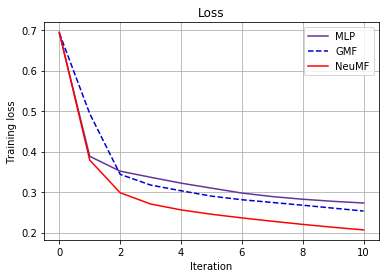

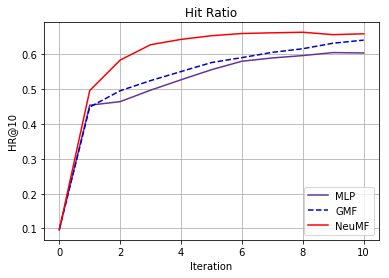

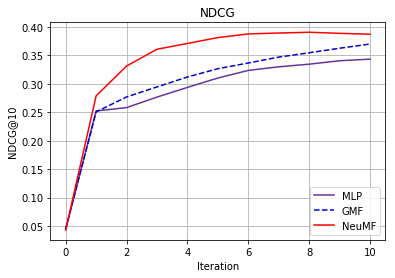

In [13]:
iterations = [e for e in range(epochs+1)]
color_MLP, color_GMF, color_NeuMF = "rebeccapurple", "mediumblue", "red"
path_to_save_figures = "Figures/MovieLens/"

plt.figure("MovieLens")
plt.plot(iterations, loss_MLP, color=color_MLP)
plt.plot(iterations, loss_GMF, color=color_GMF, linestyle="dashed")
plt.plot(iterations, loss_NeuMF, color=color_NeuMF)
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.legend(("MLP","GMF","NeuMF",))
plt.title("Loss")
plt.grid()
#plt.savefig(fname=path_to_save_figures+"loss.png")

plt.figure("MovieLens2")
plt.plot(iterations, hits_MLP, color=color_MLP)
plt.plot(iterations, hits_GMF, color=color_GMF, linestyle="dashed")
plt.plot(iterations, hits_NeuMF, color=color_NeuMF)
plt.xlabel("Iteration")
plt.ylabel("HR@"+str(K))
plt.legend(("MLP","GMF","NeuMF",))
plt.title("Hit Ratio")
plt.grid()
#plt.savefig(fname=path_to_save_figures+"hr.png")

plt.figure("MovieLens3")
plt.plot(iterations, ndcgs_MLP, color=color_MLP)
plt.plot(iterations, ndcgs_GMF, color=color_GMF, linestyle="dashed")
plt.plot(iterations, ndcgs_NeuMF, color=color_NeuMF)
plt.xlabel("Iteration")
plt.ylabel("NDCG@"+str(K))
plt.legend(("MLP","GMF","NeuMF",))
plt.title("NDCG")
plt.grid()
#plt.savefig(fname=path_to_save_figures+"ndcg.png")

plt.show()

## Affichage des résultats et comparaison des performances (Pinterest)

In [12]:
start = time()

MLP_pinterest = get_model_MLP(num_users=num_users_pinterest, num_items=num_items_pinterest, factors=8)
GMF_pinterest = get_model_GMF(num_users=num_users_pinterest, num_items=num_items_pinterest)
NeuMF_pinterest = get_model_NeuMF(num_users=num_users_pinterest, num_items=num_items_pinterest)

models_pinterest = [MLP_pinterest, GMF_pinterest, NeuMF_pinterest]

hits, ndcgs, losses = train_models(models=models_pinterest, train_features=train_features_pinterest, train_labels=train_labels_pinterest, 
                                   test_set=test_set_pinterest, batch_size=batch_size, epochs=epochs, K=K)

loss_MLP, loss_GMF, loss_NeuMF = losses[:,0], losses[:,1], losses[:,2]
hits_MLP, hits_GMF, hits_NeuMF = hits[:,0], hits[:,1], hits[:,2]
ndcgs_MLP, ndcgs_GMF, ndcgs_NeuMF = ndcgs[:,0], ndcgs[:,1], ndcgs[:,2]

run_time = time()-start
print("\nRunning time : {:.0f} min {:.0f} sec".format(run_time//60, run_time%60))


Epoch n°1/10
7228110/7228110 - 15s - loss: 0.4066
7228110/7228110 - 16s - loss: 0.5735
7228110/7228110 - 22s - loss: 0.3856

Epoch n°2/10
7228110/7228110 - 14s - loss: 0.2698
7228110/7228110 - 15s - loss: 0.3373
7228110/7228110 - 21s - loss: 0.2257

Epoch n°3/10
7228110/7228110 - 14s - loss: 0.2385
7228110/7228110 - 16s - loss: 0.2242
7228110/7228110 - 21s - loss: 0.1663

Epoch n°4/10
7228110/7228110 - 14s - loss: 0.2185
7228110/7228110 - 15s - loss: 0.1848
7228110/7228110 - 21s - loss: 0.1333

Epoch n°5/10
7228110/7228110 - 14s - loss: 0.2043
7228110/7228110 - 15s - loss: 0.1624
7228110/7228110 - 21s - loss: 0.1077

Epoch n°6/10
7228110/7228110 - 14s - loss: 0.1937
7228110/7228110 - 15s - loss: 0.1450
7228110/7228110 - 21s - loss: 0.0853

Epoch n°7/10
7228110/7228110 - 14s - loss: 0.1859
7228110/7228110 - 15s - loss: 0.1294
7228110/7228110 - 21s - loss: 0.0656

Epoch n°8/10
7228110/7228110 - 14s - loss: 0.1795
7228110/7228110 - 15s - loss: 0.1148
7228110/7228110 - 21s - loss: 0.0486


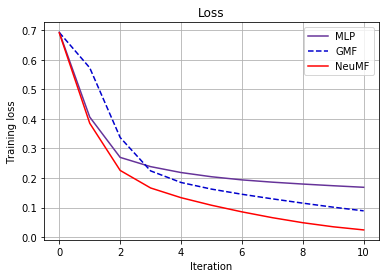

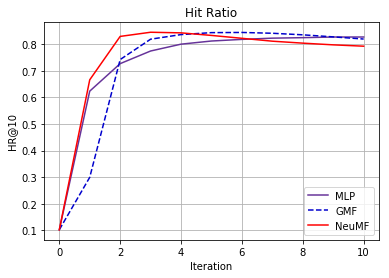

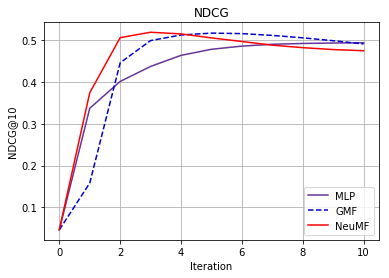

In [13]:
iterations = [e for e in range(epochs+1)]
color_MLP, color_GMF, color_NeuMF = "rebeccapurple", "mediumblue", "red"
#path_to_save_figures = "Figures/Pinterest/"

plt.figure("Pinterest")
plt.plot(iterations, loss_MLP, color=color_MLP)
plt.plot(iterations, loss_GMF, color=color_GMF, linestyle="dashed")
plt.plot(iterations, loss_NeuMF, color=color_NeuMF)
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.legend(("MLP","GMF","NeuMF",))
plt.title("Loss")
plt.grid()
#plt.savefig(fname=path_to_save_figures+"loss.png")

plt.figure("Pinterest2")
plt.plot(iterations, hits_MLP, color=color_MLP)
plt.plot(iterations, hits_GMF, color=color_GMF, linestyle="dashed")
plt.plot(iterations, hits_NeuMF, color=color_NeuMF)
plt.xlabel("Iteration")
plt.ylabel("HR@"+str(K))
plt.legend(("MLP","GMF","NeuMF",))
plt.title("Hit Ratio")
plt.grid()
#plt.savefig(fname=path_to_save_figures+"hr.png")

plt.figure("Pinterest3")
plt.plot(iterations, ndcgs_MLP, color=color_MLP)
plt.plot(iterations, ndcgs_GMF, color=color_GMF, linestyle="dashed")
plt.plot(iterations, ndcgs_NeuMF, color=color_NeuMF)
plt.xlabel("Iteration")
plt.ylabel("NDCG@"+str(K))
plt.legend(("MLP","GMF","NeuMF",))
plt.title("NDCG")
plt.grid()
#plt.savefig(fname=path_to_save_figures+"ndcg.png")

plt.show()

## Application sur un échantillon de données issues d'Amadeus [DRAFT]

Dans cette partie, nous allons entrainer les modèles sur des données fournies par Amadeus, leader dans les systèmes de réservations. Ces données ont été anonymisées, les users sont des clients d'une compagnie aérienne et les items sont des destinations de voyage.

In [16]:
travel_filepath = "Data/Travel_28K.csv"
df = pd.read_csv(filepath_or_buffer=travel_filepath)
df.head()

,user,item
0,0,7
1,0,4
2,0,46
3,0,6
4,0,37


In [17]:
def get_dataset_amadeus(travel_filepath, num_negative_instances, num_items):
    df = pd.read_csv(filepath_or_buffer=travel_filepath)
    ones = np.ones(shape=(len(df.values),1))
    positive_interactions = np.concatenate((df.values, ones), axis=1).astype(dtype="int64")
    train_set, test_set = [], []
    current_user = -1
    interactions_for_this_user = []
    for interaction in positive_interactions:
        user, item = interaction[0], interaction[1]
        if user==current_user:
            train_set.append(interaction)
            interactions_for_this_user.append(item)
        else:
            num_interactions = len(interactions_for_this_user)
            for i in range(num_negative_instances * num_interactions):
                random_item = np.random.randint(num_items)
                while (random_item in interactions_for_this_user):
                    random_item = np.random.randint(num_items)
                train_set.append([current_user, random_item, 0])
                interactions_for_this_user.append([current_user, random_item, 0])
            current_user = user
            positive_item = item
            items_test_for_this_user = [positive_item]
            if len(interactions_for_this_user)!=5*num_interactions:
                print("problem")
            interactions_for_this_user = []
            for i in range(99):
                random_item = np.random.randint(num_items)
                while random_item in items_test_for_this_user:
                    random_item = np.random.randint(num_items)
                items_test_for_this_user.append(random_item)
            test_set.append(items_test_for_this_user)
    for i in range(num_negative_instances * num_interactions):
        random_item = np.random.randint(num_items+1)
        while (random_item in interactions_for_this_user):
            random_item = np.random.randint(num_items+1)
        train_set.append([current_user, random_item, 0])
    return np.array(train_set), np.array(test_set)

In [18]:
print("\n*** Preprocessing of data ***")

num_users_amadeus, num_items_amadeus = number_users_and_items(path=travel_filepath, sep=",", title_columns=True)
train_set_amadeus, test_set_amadeus = get_dataset_amadeus(travel_filepath=travel_filepath, num_negative_instances=4, num_items=num_items_amadeus)
#train_set_amadeus = get_train_set(path=travel_filepath, num_negative_instances=4, sep=",")
print("\nDataset Amadeus")
print("Number of users : {}".format(num_users_amadeus))
print("Number of items : {}".format(num_items_amadeus))
print("Number of training interactions : {}".format(len(train_set_amadeus)))
train_features_amadeus = [train_set_amadeus[:,0], train_set_amadeus[:,1]]
train_labels_amadeus = train_set_amadeus[:,2]

print("\nDataset loaded successfully !")


*** Preprocessing of data ***

Dataset Amadeus
Number of users : 3842
Number of items : 138
Number of training interactions : 122630

Dataset loaded successfully !


In [19]:
train_set_amadeus

array([[   0,    4,    1],
       [   0,   46,    1],
       [   0,    6,    1],
       ...,
       [3841,   54,    0],
       [3841,   85,    0],
       [3841,   70,    0]])

In [20]:
test_set_amadeus

array([[  7,  66,  73, ...,  94,  88,  55],
       [ 37,   2, 112, ...,  88,  91, 126],
       [  0,  42, 107, ...,  95, 125,  20],
       ...,
       [  0,  73,  10, ...,  58,  79,  47],
       [ 51,  69,  49, ...,   5,  65,  77],
       [  4,  40,   8, ...,  43,  35,  64]])

In [21]:
train_set_amadeus[:50]

array([[  0,   4,   1],
       [  0,  46,   1],
       [  0,   6,   1],
       [  0,  37,   1],
       [  0,   0,   1],
       [  0,  17,   1],
       [  0,  39,   1],
       [  0,  27,   1],
       [  0,  42,   1],
       [  0,  22,   0],
       [  0,  56,   0],
       [  0,   5,   0],
       [  0,  83,   0],
       [  0,  73,   0],
       [  0,  94,   0],
       [  0,  33,   0],
       [  0,   7,   0],
       [  0, 117,   0],
       [  0, 104,   0],
       [  0,   3,   0],
       [  0,  45,   0],
       [  0,  35,   0],
       [  0,  36,   0],
       [  0, 137,   0],
       [  0,  71,   0],
       [  0, 132,   0],
       [  0,  15,   0],
       [  0,  52,   0],
       [  0,  95,   0],
       [  0,  60,   0],
       [  0,  67,   0],
       [  0,  45,   0],
       [  0,  64,   0],
       [  0,  16,   0],
       [  0,  49,   0],
       [  0, 135,   0],
       [  0,  32,   0],
       [  0, 128,   0],
       [  0,  48,   0],
       [  0, 109,   0],
       [  0,  90,   0],
       [  0,  41

In [24]:
test_set_amadeus[0]

array([  7,  66,  73,  86, 128,  40,  63, 109,  20,  24,  23,  49, 125,
         0, 122,  65,  42,   4,  90, 111,   1, 119, 112,   9,  36,  89,
        69,  71, 115, 118, 103,  87,  15,  17,  82,  47,   3,  32, 134,
        57,  96,  46,  28,  52,  31,  16,  84,  83,  62,  78,  81,  43,
        50,  56,  12, 105,   2,  93, 120, 124,  70,  35,   8, 137,  67,
       100, 136,  64, 129, 106,  60,  85,  75, 135,  98,   6,  79,  26,
        77,  91,  33,  61, 132,  22, 104,  74,  39,  37,  45,  19,  97,
       113,   5,  25,  54, 101, 110,  94,  88,  55])

In [27]:
start = time()

MLP_amadeus = get_model_MLP(num_users=num_users_amadeus, num_items=num_items_amadeus, factors=8)
GMF_amadeus = get_model_GMF(num_users=num_users_amadeus, num_items=num_items_amadeus)
NeuMF_amadeus = get_model_NeuMF(num_users=num_users_amadeus, num_items=num_items_amadeus)

models_amadeus = [MLP_amadeus, GMF_amadeus, NeuMF_amadeus]

hits, ndcgs, losses = train_models(models=models_amadeus, train_features=train_features_amadeus, train_labels=train_labels_amadeus, 
                                   test_set=test_set_amadeus, batch_size=256, epochs=epochs, K=K)

loss_MLP, loss_GMF, loss_NeuMF = losses[:,0], losses[:,1], losses[:,2]
hits_MLP, hits_GMF, hits_NeuMF = hits[:,0], hits[:,1], hits[:,2]
ndcgs_MLP, ndcgs_GMF, ndcgs_NeuMF = ndcgs[:,0], ndcgs[:,1], ndcgs[:,2]

run_time = time()-start
print("\nRunning time : {:.0f} min {:.0f} sec".format(run_time//60, run_time%60))


Epoch n°1/10
122630/122630 - 2s - loss: 0.3598
122630/122630 - 2s - loss: 0.6135
122630/122630 - 3s - loss: 0.3527

Epoch n°2/10
122630/122630 - 2s - loss: 0.3118
122630/122630 - 2s - loss: 0.3423
122630/122630 - 2s - loss: 0.2996

Epoch n°3/10
122630/122630 - 2s - loss: 0.2999
122630/122630 - 2s - loss: 0.2810
122630/122630 - 2s - loss: 0.2296

Epoch n°4/10
122630/122630 - 2s - loss: 0.2798
122630/122630 - 1s - loss: 0.2410
122630/122630 - 2s - loss: 0.1539

Epoch n°5/10
122630/122630 - 2s - loss: 0.2523
122630/122630 - 2s - loss: 0.2076
122630/122630 - 2s - loss: 0.0956

Epoch n°6/10
122630/122630 - 2s - loss: 0.2270
122630/122630 - 2s - loss: 0.1764
122630/122630 - 2s - loss: 0.0580

Epoch n°7/10
122630/122630 - 2s - loss: 0.2043
122630/122630 - 2s - loss: 0.1474
122630/122630 - 2s - loss: 0.0357

Epoch n°8/10
122630/122630 - 2s - loss: 0.1850
122630/122630 - 2s - loss: 0.1211
122630/122630 - 2s - loss: 0.0226

Epoch n°9/10
122630/122630 - 2s - loss: 0.1666
122630/122630 - 2s - los

In [36]:
MLP_amadeus.predict(x=np.array([[np.array(0), np.array(7)]]).reshape(-1,1))

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[0],
       [7]])]...

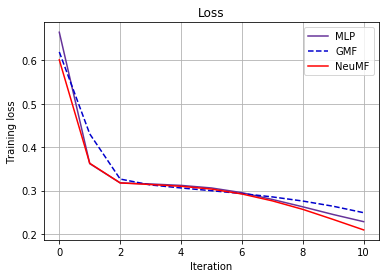

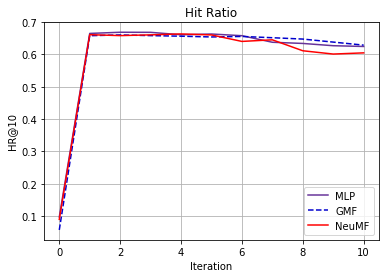

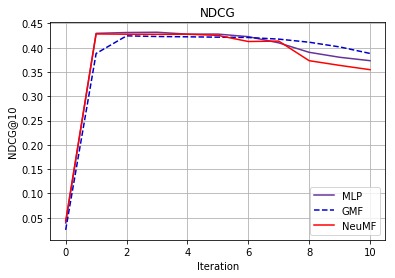

In [57]:
iterations = [e for e in range(epochs+1)]
color_MLP, color_GMF, color_NeuMF = "rebeccapurple", "mediumblue", "red"
path_to_save_figures = "Figures/Amadeus/"

plt.figure("Amadeus")
plt.plot(iterations, loss_MLP, color=color_MLP)
plt.plot(iterations, loss_GMF, color=color_GMF, linestyle="dashed")
plt.plot(iterations, loss_NeuMF, color=color_NeuMF)
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.legend(("MLP","GMF","NeuMF",))
plt.title("Loss")
plt.grid()
plt.savefig(fname=path_to_save_figures+"loss.png")

plt.figure("Amadeus2")
plt.plot(iterations, hits_MLP, color=color_MLP)
plt.plot(iterations, hits_GMF, color=color_GMF, linestyle="dashed")
plt.plot(iterations, hits_NeuMF, color=color_NeuMF)
plt.xlabel("Iteration")
plt.ylabel("HR@"+str(K))
plt.legend(("MLP","GMF","NeuMF",))
plt.title("Hit Ratio")
plt.grid()
plt.savefig(fname=path_to_save_figures+"hr.png")

plt.figure("Amadeus3")
plt.plot(iterations, ndcgs_MLP, color=color_MLP)
plt.plot(iterations, ndcgs_GMF, color=color_GMF, linestyle="dashed")
plt.plot(iterations, ndcgs_NeuMF, color=color_NeuMF)
plt.xlabel("Iteration")
plt.ylabel("NDCG@"+str(K))
plt.legend(("MLP","GMF","NeuMF",))
plt.title("NDCG")
plt.grid()
plt.savefig(fname=path_to_save_figures+"ndcg.png")

plt.show()

## Expériences : Etude des différents paramètres

L'objectif de cette partie est d'observer le comportement des modèles lorsqu'on fait varier un paramètre tout en gardant tous les autres fixés. Les paramètres à étudier sont l'architecture du MLP (nombre de couches ou nombre de neurones par couche), la taille des embeddings (facteurs latents), le nombre K pour calculer les metriques HR et NDCG et enfin le nombre d'interactions négatives par interaction positive dans le jeu de données d'entrainement.

### Expérience 1 : Comparaison des performances des modèles

#### Dataset MovieLens

In [38]:
start = time()

MF_movielens = get_model_MF(num_users=num_users_movielens, num_items=num_items_movielens, factors=8)
GMF_movielens = get_model_GMF(num_users=num_users_movielens, num_items=num_items_movielens, factors=8)
MLP_movielens = get_model_MLP(num_users=num_users_movielens, num_items=num_items_movielens, layers=[32,16,8])
NeuMF_movielens = get_model_NeuMF2(num_users=num_users_movielens, num_items=num_items_movielens, layers=[16,8,4])

models_movielens = [MF_movielens, GMF_movielens, MLP_movielens, NeuMF_movielens]

hits, ndcgs, losses = train_models(models=models_movielens, train_features=train_features_movielens, train_labels=train_labels_movielens, 
                                   test_set=test_set_movielens, batch_size=batch_size, epochs=epochs, K=K)

loss_MF, loss_GMF, loss_MLP, loss_NeuMF = losses[:,0], losses[:,1], losses[:,2], losses[:,3]
hits_MF, hits_GMF, hits_MLP, hits_NeuMF = hits[:,0], hits[:,1], hits[:,2], hits[:,3]
ndcgs_MF, ndcgs_GMF, ndcgs_MLP, ndcgs_NeuMF = ndcgs[:,0], ndcgs[:,1], ndcgs[:,2], ndcgs[:,3]

run_time = time()-start
print("\nRunning time : {:.0f} min {:.0f} sec".format(run_time//60, run_time%60))


Epoch n°1/10
4970845/4970845 - 8s - loss: 2.1015
4970845/4970845 - 8s - loss: 0.5253
4970845/4970845 - 12s - loss: 0.3827
4970845/4970845 - 11s - loss: 0.4180

Epoch n°2/10
4970845/4970845 - 6s - loss: 1.5492
4970845/4970845 - 7s - loss: 0.3610
4970845/4970845 - 10s - loss: 0.3492
4970845/4970845 - 10s - loss: 0.3288

Epoch n°3/10
4970845/4970845 - 6s - loss: 0.9633
4970845/4970845 - 7s - loss: 0.3548
4970845/4970845 - 10s - loss: 0.3278
4970845/4970845 - 10s - loss: 0.3085

Epoch n°4/10
4970845/4970845 - 6s - loss: 0.7587
4970845/4970845 - 7s - loss: 0.3523
4970845/4970845 - 10s - loss: 0.3124
4970845/4970845 - 10s - loss: 0.3000

Epoch n°5/10
4970845/4970845 - 6s - loss: 0.6639
4970845/4970845 - 7s - loss: 0.3476
4970845/4970845 - 10s - loss: 0.3008
4970845/4970845 - 10s - loss: 0.2947

Epoch n°6/10
4970845/4970845 - 6s - loss: 0.5978
4970845/4970845 - 7s - loss: 0.3369
4970845/4970845 - 10s - loss: 0.2931
4970845/4970845 - 10s - loss: 0.2906

Epoch n°7/10
4970845/4970845 - 6s - los

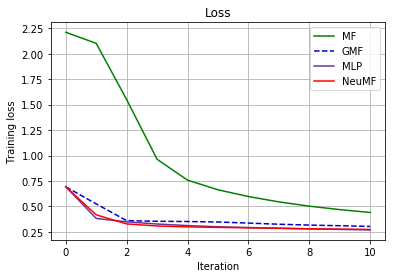

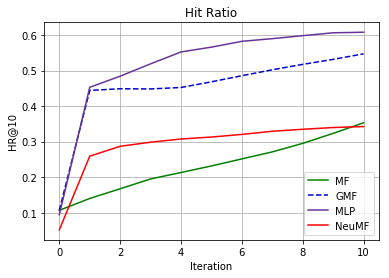

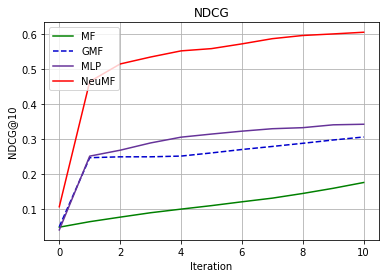

In [41]:
iterations = [e for e in range(epochs+1)]
color_MF, color_GMF, color_MLP, color_NeuMF = "green", "mediumblue", "rebeccapurple", "red"
path_to_save_figures = "Figures/"

plt.figure("loss_movieLens")
plt.plot(iterations, loss_MF, color=color_MF)
plt.plot(iterations, loss_GMF, color=color_GMF, linestyle="dashed")
plt.plot(iterations, loss_MLP, color=color_MLP)
plt.plot(iterations, loss_NeuMF, color=color_NeuMF)
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.legend(("MF", "GMF","MLP","NeuMF",))
plt.title("Loss")
plt.grid()
#plt.savefig(fname=path_to_save_figures+"experiment1_loss_movielens.png")

plt.figure("hits_movieLens")
plt.plot(iterations, hits_MF, color=color_MF)
plt.plot(iterations, hits_GMF, color=color_GMF, linestyle="dashed")
plt.plot(iterations, hits_MLP, color=color_MLP)
plt.plot(iterations, ndcgs_NeuMF, color=color_NeuMF)
plt.xlabel("Iteration")
plt.ylabel("HR@"+str(K))
plt.legend(("MF", "GMF","MLP","NeuMF",))
plt.title("Hit Ratio")
plt.grid()
#plt.savefig(fname=path_to_save_figures+"experiment1_hr_movielens.png")

plt.figure("ndcgs_movielens")
plt.plot(iterations, ndcgs_MF, color=color_MF)
plt.plot(iterations, ndcgs_GMF, color=color_GMF, linestyle="dashed")
plt.plot(iterations, ndcgs_MLP, color=color_MLP)
plt.plot(iterations, hits_NeuMF, color=color_NeuMF)
plt.xlabel("Iteration")
plt.ylabel("NDCG@"+str(K))
plt.legend(("MF", "GMF","MLP","NeuMF",))
plt.title("NDCG")
plt.grid()
#plt.savefig(fname=path_to_save_figures+"experiment1_ndcg_movielens.png")

plt.show()

#### Dataset Pinterest

In [42]:
start = time()

MF_pinterest = get_model_MF(num_users=num_users_pinterest, num_items=num_items_pinterest, factors=8)
GMF_pinterest = get_model_GMF(num_users=num_users_pinterest, num_items=num_items_pinterest, factors=8)
MLP_pinterest = get_model_MLP(num_users=num_users_pinterest, num_items=num_items_pinterest, layers=[32,16,8])
NeuMF_pinterest = get_model_NeuMF2(num_users=num_users_pinterest, num_items=num_items_pinterest, layers=[16,8,4])

models_pinterest = [MF_pinterest, GMF_pinterest, MLP_pinterest, NeuMF_pinterest]

hits, ndcgs, losses = train_models(models=models_pinterest, train_features=train_features_pinterest, train_labels=train_labels_pinterest, 
                                   test_set=test_set_pinterest, batch_size=batch_size, epochs=epochs, K=K)

loss_MF, loss_GMF, loss_MLP, loss_NeuMF = losses[:,0], losses[:,1], losses[:,2], losses[:,3]
hits_MF, hits_GMF, hits_MLP, hits_NeuMF = hits[:,0], hits[:,1], hits[:,2], hits[:,3]
ndcgs_MF, ndcgs_GMF, ndcgs_MLP, ndcgs_NeuMF = ndcgs[:,0], ndcgs[:,1], ndcgs[:,2], ndcgs[:,3]

run_time = time()-start
print("\nRunning time : {:.0f} min {:.0f} sec".format(run_time//60, run_time%60))


Epoch n°1/10
7228110/7228110 - 15s - loss: 2.1341
7228110/7228110 - 15s - loss: 0.5905
7228110/7228110 - 19s - loss: 0.4144
7228110/7228110 - 19s - loss: 0.4442

Epoch n°2/10
7228110/7228110 - 13s - loss: 1.8503
7228110/7228110 - 13s - loss: 0.4064
7228110/7228110 - 17s - loss: 0.2674
7228110/7228110 - 17s - loss: 0.2810

Epoch n°3/10
7228110/7228110 - 13s - loss: 1.6272
7228110/7228110 - 13s - loss: 0.3220
7228110/7228110 - 17s - loss: 0.2361
7228110/7228110 - 17s - loss: 0.2238

Epoch n°4/10
7228110/7228110 - 13s - loss: 1.3854
7228110/7228110 - 13s - loss: 0.2628
7228110/7228110 - 17s - loss: 0.2157
7228110/7228110 - 17s - loss: 0.2005

Epoch n°5/10
7228110/7228110 - 13s - loss: 1.1369
7228110/7228110 - 13s - loss: 0.2304
7228110/7228110 - 17s - loss: 0.2019
7228110/7228110 - 17s - loss: 0.1874

Epoch n°6/10
7228110/7228110 - 13s - loss: 0.9207
7228110/7228110 - 13s - loss: 0.2113
7228110/7228110 - 17s - loss: 0.1923
7228110/7228110 - 17s - loss: 0.1789

Epoch n°7/10
7228110/722811

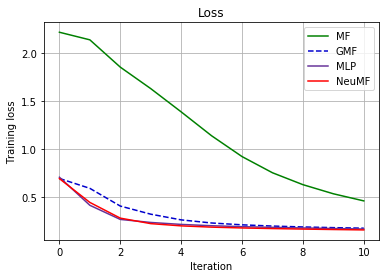

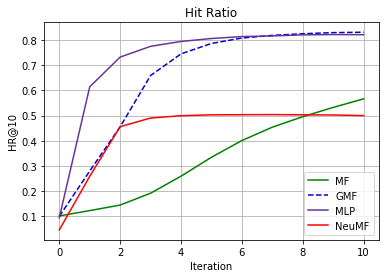

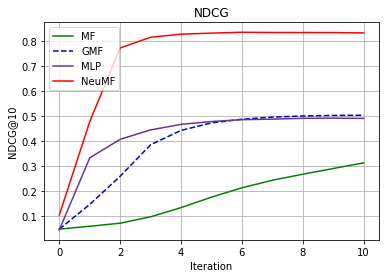

In [44]:
iterations = [e for e in range(epochs+1)]
color_MF, color_GMF, color_MLP, color_NeuMF = "green", "mediumblue", "rebeccapurple", "red"
path_to_save_figures = "Figures/"

plt.figure("loss_pinterest")
plt.plot(iterations, loss_MF, color=color_MF)
plt.plot(iterations, loss_GMF, color=color_GMF, linestyle="dashed")
plt.plot(iterations, loss_MLP, color=color_MLP)
plt.plot(iterations, loss_NeuMF, color=color_NeuMF)
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.legend(("MF", "GMF","MLP","NeuMF",))
plt.title("Loss")
plt.grid()
#plt.savefig(fname=path_to_save_figures+"experiment1_loss_pinterest.png")

plt.figure("hits_pinterest")
plt.plot(iterations, hits_MF, color=color_MF)
plt.plot(iterations, hits_GMF, color=color_GMF, linestyle="dashed")
plt.plot(iterations, hits_MLP, color=color_MLP)
plt.plot(iterations, ndcgs_NeuMF, color=color_NeuMF)
plt.xlabel("Iteration")
plt.ylabel("HR@"+str(K))
plt.legend(("MF", "GMF","MLP","NeuMF",))
plt.title("Hit Ratio")
plt.grid()
#plt.savefig(fname=path_to_save_figures+"experiment1_hr_pinterest.png")

plt.figure("ndcgs_pinterest")
plt.plot(iterations, ndcgs_MF, color=color_MF)
plt.plot(iterations, ndcgs_GMF, color=color_GMF, linestyle="dashed")
plt.plot(iterations, ndcgs_MLP, color=color_MLP)
plt.plot(iterations, hits_NeuMF, color=color_NeuMF)
plt.xlabel("Iteration")
plt.ylabel("NDCG@"+str(K))
plt.legend(("MF", "GMF","MLP","NeuMF",))
plt.title("NDCG")
plt.grid()
#plt.savefig(fname=path_to_save_figures+"experiment1_ndcg_pinterest.png")

plt.show()

### Expérience 2 : Le nombre N d'interactions négatives par interaction positive

Nous allons commencer par faire varier le nombre d'interaction négatives par interaction positive dans le train set. On va donc entrainer nos 3 modèles sur 3 epochs (les entrainer plus prendrait trop de temps et n'apporte pas d'information supplémentaire) avec le dataset MovieLens. On choisira un nombre de facteurs latents égal à 16.

#### Dataset MovieLens

In [25]:
start = time()

names_models = {0: "MF", 2: "GMF", 1: "MLP", 3: "NeuMF"}

max_num_negative = 10
hits_total, ndcgs_total = [], []
for i in range(1, max_num_negative+1):
    print("\nNumber of negative interactions per positive interaction in train set : {}".format(i))
    train_set = get_train_set(path=train_file_path_movielens, num_negative_instances=i, num_items=num_items_movielens)
    train_features = [train_set[:,0], train_set[:,1]]
    train_labels = train_set[:,2]
    # pour chaque nombre d'instances négatives il faut créer de nouveau modèles et les entrainer à partir de 0
    MF_movielens = get_model_MF(num_users=num_users_movielens, num_items=num_items_movielens, factors=16)
    GMF_movielens = get_model_GMF(num_users=num_users_movielens, num_items=num_items_movielens, factors=16)
    MLP_movielens = get_model_MLP(num_users=num_users_movielens, num_items=num_items_movielens, layers=[64,32,16])
    NeuMF_movielens = get_model_NeuMF2(num_users=num_users_movielens, num_items=num_items_movielens, layers=[32,16,8])
    models_movielens = [MF_movielens, GMF_movielens, MLP_movielens, NeuMF_movielens]
    k=0
    for model in models_movielens:
        print("-- Training of model {}...".format(names_models[k]))
        history = model.fit(x=train_features, y=train_labels, batch_size=batch_size, epochs=3, verbose=0, shuffle=True)
        k+=1
    print("Evaluation...")
    hits, ndcgs = evaluate_models(models=models_movielens, test_set=test_set_movielens, K=K)
    hits_total.append(hits)
    ndcgs_total.append(ndcgs)

hits_total, ndcgs_total = np.array(hits_total), np.array(ndcgs_total)

hits_MF, hits_GMF, hits_MLP, hits_NeuMF = hits_total[:,0], hits_total[:,1], hits_total[:,2], hits_total[:,3]
ndcgs_MF, ndcgs_GMF, ndcgs_MLP, ndcgs_NeuMF = ndcgs_total[:,0], ndcgs_total[:,1], ndcgs_total[:,2], ndcgs_total[:,3]

run_time = time()-start
print("\nRunning time : {:.0f} min {:.0f} sec".format(run_time//60, run_time%60))


Number of negative interactions per positive interaction in train set : 1
-- Training of model MF...
-- Training of model MLP...
-- Training of model GMF...
-- Training of model NeuMF...
Evaluation...

Number of negative interactions per positive interaction in train set : 2
-- Training of model MF...
-- Training of model MLP...
-- Training of model GMF...
-- Training of model NeuMF...
Evaluation...

Number of negative interactions per positive interaction in train set : 3
-- Training of model MF...
-- Training of model MLP...
-- Training of model GMF...
-- Training of model NeuMF...
Evaluation...

Number of negative interactions per positive interaction in train set : 4
-- Training of model MF...
-- Training of model MLP...
-- Training of model GMF...
-- Training of model NeuMF...
Evaluation...

Number of negative interactions per positive interaction in train set : 5
-- Training of model MF...
-- Training of model MLP...
-- Training of model GMF...
-- Training of model NeuMF...
Eval

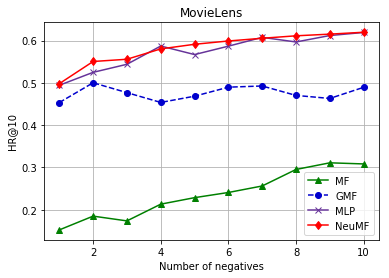

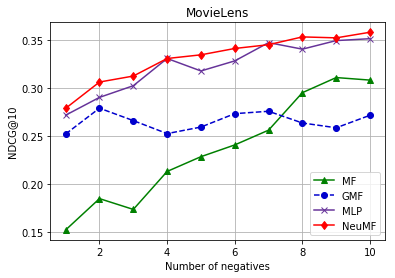

In [27]:
negatives = [i for i in range(1,max_num_negative+1)]
color_MF, color_GMF, color_MLP, color_NeuMF = "green", "mediumblue", "rebeccapurple", "red"
path_to_save_figures = "Figures/"

plt.figure("Negative")
plt.plot(negatives, hits_MF, color=color_MF, marker="^")
plt.plot(negatives, hits_GMF, color=color_GMF, linestyle="dashed", marker="o")
plt.plot(negatives, hits_MLP, color=color_MLP, marker="x")
plt.plot(negatives, hits_NeuMF, color=color_NeuMF, marker="d")
plt.xlabel("Number of negatives")
plt.ylabel("HR@"+str(K))
plt.legend(("MF","GMF","MLP","NeuMF",))
plt.title("MovieLens")
plt.grid()
#plt.savefig(fname=path_to_save_figures+"experiment2_hr_movielens.png")

plt.figure("Negative2")
plt.plot(negatives, hits_MF, color=color_MF, marker="^")
plt.plot(negatives, ndcgs_GMF, color=color_GMF, linestyle="dashed", marker="o")
plt.plot(negatives, ndcgs_MLP, color=color_MLP, marker="x")
plt.plot(negatives, ndcgs_NeuMF, color=color_NeuMF, marker="d")
plt.xlabel("Number of negatives")
plt.ylabel("NDCG@"+str(K))
plt.legend(("MF","GMF","MLP","NeuMF",))
plt.title("MovieLens")
plt.grid()
#plt.savefig(fname=path_to_save_figures+"experiment2_ndcg_movielens.png")

plt.show()

#### Dataset Pinterest

In [ ]:
start = time()

names_models = {0: "MF", 2: "GMF", 1: "MLP", 3: "NeuMF"}

max_num_negative = 10
hits_total, ndcgs_total = [], []
for i in range(1, max_num_negative+1):
    print("\nNumber of negative interactions per positive interaction in train set : {}".format(i))
    train_set = get_train_set(path=train_file_path_pinterest, num_negative_instances=i, num_items=num_items_pinterest)
    train_features = [train_set[:,0], train_set[:,1]]
    train_labels = train_set[:,2]
    # pour chaque nombre d'instances négatives il faut entrainer de nouveaux modèles
    MF_pinterest = get_model_MF(num_users=num_users_pinterest, num_items=num_items_pinterest, factors=8)
    GMF_pinterest = get_model_GMF(num_users=num_users_pinterest, num_items=num_items_pinterest, factors=8)
    MLP_pinterest = get_model_MLP(num_users=num_users_pinterest, num_items=num_items_pinterest, layers=[32,16,8])
    NeuMF_pinterest = get_model_NeuMF2(num_users=num_users_pinterest, num_items=num_items_pinterest, layers=[16,8,4])
    models_pinterest = [MF_pinterest, GMF_pinterest, MLP_pinterest, NeuMF_pinterest]
    k=0
    for model in models_pinterest:
        print("-- Training of model {}...".format(names_models[k]))
        history = model.fit(x=train_features, y=train_labels, batch_size=batch_size, epochs=3, verbose=0, shuffle=True)
        k+=1
    print("Evaluation...")
    hits, ndcgs = evaluate_models(models=models_pinterest, test_set=test_set_pinterest, K=K)
    hits_total.append(hits)
    ndcgs_total.append(ndcgs)

hits_total, ndcgs_total= np.array(hits_total), np.array(ndcgs_total)

hits_MF, hits_GMF, hits_MLP, hits_NeuMF = hits_total[:,0], hits_total[:,1], hits_total[:,2], hits_total[:,3]
ndcgs_MF, ndcgs_GMF, ndcgs_MLP, ndcgs_NeuMF = ndcgs_total[:,0], ndcgs_total[:,1], ndcgs_total[:,2], ndcgs_total[:,3]

run_time = time()-start
print("\nRunning time : {:.0f} min {:.0f} sec".format(run_time//60, run_time%60))


Number of negative interactions per positive interaction in train set : 1
-- Training of model MF...
-- Training of model MLP...
-- Training of model GMF...
-- Training of model NeuMF...
Evaluation...

Number of negative interactions per positive interaction in train set : 2
-- Training of model MF...
-- Training of model MLP...
-- Training of model GMF...
-- Training of model NeuMF...
Evaluation...

Number of negative interactions per positive interaction in train set : 3
-- Training of model MF...
-- Training of model MLP...
-- Training of model GMF...
-- Training of model NeuMF...
Evaluation...

Number of negative interactions per positive interaction in train set : 4
-- Training of model MF...
-- Training of model MLP...
-- Training of model GMF...
-- Training of model NeuMF...
Evaluation...

Number of negative interactions per positive interaction in train set : 5
-- Training of model MF...
-- Training of model MLP...
-- Training of model GMF...
-- Training of model NeuMF...
Eval

In [ ]:
negatives = [i for i in range(1,max_num_negative+1)]
color_MF, color_GMF, color_MLP, color_NeuMF = "green", "mediumblue", "rebeccapurple", "red"
path_to_save_figures = "Figures/"

plt.figure("Negative")
plt.plot(negatives, hits_MF, color=color_MF, marker="^")
plt.plot(negatives, hits_GMF, color=color_GMF, linestyle="dashed", marker="o")
plt.plot(negatives, hits_MLP, color=color_MLP, marker="x")
plt.plot(negatives, hits_NeuMF, color=color_NeuMF, marker="d")
plt.xlabel("Number of negatives")
plt.ylabel("HR@"+str(K))
plt.legend(("MF","GMF","MLP","NeuMF",))
plt.title("Pinterest")
plt.grid()
plt.savefig(fname=path_to_save_figures+"experiment2_hr_pinterest.png")

plt.figure("Negative2")
plt.plot(negatives, hits_MF, color=color_MF, marker="^")
plt.plot(negatives, ndcgs_GMF, color=color_GMF, linestyle="dashed", marker="o")
plt.plot(negatives, ndcgs_MLP, color=color_MLP, marker="x")
plt.plot(negatives, ndcgs_NeuMF, color=color_NeuMF, marker="d")
plt.xlabel("Number of negatives")
plt.ylabel("NDCG@"+str(K))
plt.legend(("MF","GMF","MLP","NeuMF",))
plt.title("Pinterest")
plt.grid()
plt.savefig(fname=path_to_save_figures+"experiment2_ndcg_pinterest.png")

plt.show()

### Expérience 3 : Le nombre de facteurs predictifs

Nous allons maintenant faire varier le nombre de facteurs predictifs, qui correspond à la dimension de la dernière couche avant le neurone finale qui calcule le score d'interaction. Nous entrainerons les modèles avec les nombres de facteurs suivants : 8, 16, 32 et 64. On commence avec le dataset MovieLens, puis on fait de même avec Pinterest.

#### Dataset MovieLens

In [56]:
start = time()

factors = [8,16,32,64]
hits, ndcgs = [], []

for f in factors:
    print("Training for {:.0f} predictive factors...".format(f))
    layers_MLP, layers_NeuMF = [4*f, 2*f, f], [2*f, f, int(f/2)]
    MF = get_model_MF(num_users=num_users_movielens, num_items=num_items_movielens, factors=f)
    GMF = get_model_MF(num_users=num_users_movielens, num_items=num_items_movielens, factors=f)
    MLP = get_model_MLP(num_users=num_users_movielens, num_items=num_items_movielens, layers=layers_MLP)
    Neu_MF = get_model_NeuMF2(num_users=num_users_movielens, num_items=num_items_movielens, layers=layers_NeuMF)
    models = [MF, GMF, MLP, NeuMF]
    for model in models:
        model.fit(x=train_features_movielens, y=train_labels_movielens, batch_size=batch_size, epochs=3, verbose=0, shuffle=True)
    print("Evaluation...\n")
    hit, ndcg = evaluate_models(models=models, test_set=test_set_movielens, K=K)
    hits.append(hit)
    ndcgs.append(ndcg)

hits, ndcgs = np.array(hits), np.array(ndcgs)

hits_MF, hits_GMF, hits_MLP, hits_NeuMF = hits[:,0], hits[:,1], hits[:,2], hits[:,3]
ndcgs_MF, ndcgs_GMF, ndcgs_MLP, ndcgs_NeuMF = ndcgs[:,0], ndcgs[:,1], ndcgs[:,2], ndcgs[:,3]

run_time = time()-start
print("\nRunning time : {:.0f} min {:.0f} sec".format(run_time//60, run_time%60))

Training for 8 predictive factors...
Evaluation...

Training for 16 predictive factors...
Evaluation...

Training for 32 predictive factors...
Evaluation...

Training for 64 predictive factors...
Evaluation...


Running time : 13 min 48 sec


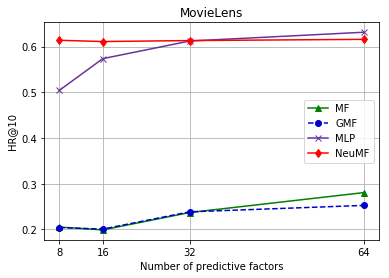

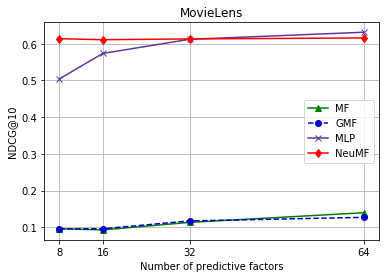

In [58]:
color_MF, color_GMF, color_MLP, color_NeuMF = "green", "mediumblue", "rebeccapurple", "red"
path_to_save_figures = "Figures/"

plt.figure("Factors")
plt.plot(factors, hits_MF, color=color_MF, marker="^")
plt.plot(factors, hits_GMF, color=color_GMF, marker="o", linestyle="dashed")
plt.plot(factors, hits_MLP, color=color_MLP, marker="x")
plt.plot(factors, hits_NeuMF, color=color_NeuMF, marker="d")
plt.xlabel("Number of predictive factors")
plt.ylabel("HR@"+str(K))
plt.legend(("MF","GMF","MLP","NeuMF",))
plt.title("MovieLens")
plt.xticks(factors)
plt.grid()
#plt.savefig(fname=path_to_save_figures+"experiment3_hr_movielens.png")

plt.figure("Factors2")
plt.plot(factors, ndcgs_MF, color=color_MF, marker="^")
plt.plot(factors, ndcgs_GMF, color=color_GMF, marker="o", linestyle="dashed")
plt.plot(factors, hits_MLP, color=color_MLP, marker="x")
plt.plot(factors, hits_NeuMF, color=color_NeuMF, marker="d")
plt.xlabel("Number of predictive factors")
plt.ylabel("NDCG@"+str(K))
plt.legend(("MF","GMF","MLP","NeuMF",))
plt.title("MovieLens")
plt.xticks(factors)
plt.grid()
#plt.savefig(fname=path_to_save_figures+"experiment3_ndcg_movielens.png")

plt.show()

#### Dataset Pinterest

On fait de même sur le dataset Pinterest.

In [60]:
start = time()

factors = [8,16,32,64]
hits, ndcgs = [], []

for f in factors:
    print("Training for {:.0f} predictive factors...".format(f))
    layers_MLP, layers_NeuMF = [4*f, 2*f, f], [2*f, f, int(f/2)]
    MF = get_model_MF(num_users=num_users_pinterest, num_items=num_items_pinterest, factors=f)
    GMF = get_model_MF(num_users=num_users_pinterest, num_items=num_items_pinterest, factors=f)
    MLP = get_model_MLP(num_users=num_users_pinterest, num_items=num_items_pinterest, layers=layers_MLP)
    Neu_MF = get_model_NeuMF2(num_users=num_users_pinterest, num_items=num_items_pinterest, layers=layers_NeuMF)
    models = [MF, GMF, MLP, NeuMF]
    for model in models:
        model.fit(x=train_features_pinterest, y=train_labels_pinterest, batch_size=batch_size, epochs=3, verbose=0, shuffle=True)
    print("Evaluation...\n")
    hit, ndcg = evaluate_models(models=models, test_set=test_set_pinterest, K=K)
    hits.append(hit)
    ndcgs.append(ndcg)

hits, ndcgs = np.array(hits), np.array(ndcgs)

hits_MF, hits_GMF, hits_MLP, hits_NeuMF = hits[:,0], hits[:,1], hits[:,2], hits[:,3]
ndcgs_MF, ndcgs_GMF, ndcgs_MLP, ndcgs_NeuMF = ndcgs[:,0], ndcgs[:,1], ndcgs[:,2], ndcgs[:,3]

run_time = time()-start
print("\nRunning time : {:.0f} min {:.0f} sec".format(run_time//60, run_time%60))

Training for 8 predictive factors...
Evaluation...

Training for 16 predictive factors...
Evaluation...

Training for 32 predictive factors...
Evaluation...

Training for 64 predictive factors...
Evaluation...


Running time : 27 min 28 sec


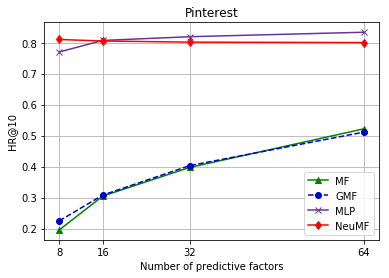

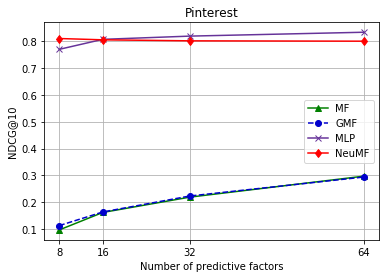

In [62]:
color_MF, color_GMF, color_MLP, color_NeuMF = "green", "mediumblue", "rebeccapurple", "red"
path_to_save_figures = "Figures/"

plt.figure("Factors")
plt.plot(factors, hits_MF, color=color_MF, marker="^")
plt.plot(factors, hits_GMF, color=color_GMF, marker="o", linestyle="dashed")
plt.plot(factors, hits_MLP, color=color_MLP, marker="x")
plt.plot(factors, hits_NeuMF, color=color_NeuMF, marker="d")
plt.xlabel("Number of predictive factors")
plt.ylabel("HR@"+str(K))
plt.legend(("MF","GMF","MLP","NeuMF",))
plt.title("Pinterest")
plt.xticks(factors)
plt.grid()
plt.savefig(fname=path_to_save_figures+"experiment3_hr_pinterest.png")

plt.figure("Factors2")
plt.plot(factors, ndcgs_MF, color=color_MF, marker="^")
plt.plot(factors, ndcgs_GMF, color=color_GMF, marker="o", linestyle="dashed")
plt.plot(factors, hits_MLP, color=color_MLP, marker="x")
plt.plot(factors, hits_NeuMF, color=color_NeuMF, marker="d")
plt.xlabel("Number of predictive factors")
plt.ylabel("NDCG@"+str(K))
plt.legend(("MF","GMF","MLP","NeuMF",))
plt.title("Pinterest")
plt.xticks(factors)
plt.grid()
plt.savefig(fname=path_to_save_figures+"experiment3_ndcg_pinterest.png")

plt.show()

### Expérience 4 : Le paramètre K lors de l'évaluation des modèles

#### Dataset MovieLens

In [18]:
MF = get_model_MF(num_users=num_users_movielens, num_items=num_items_movielens, factors=8)
GMF = get_model_GMF(num_users=num_users_movielens, num_items=num_items_movielens, factors=8)
MLP = get_model_MLP(num_users=num_users_movielens, num_items=num_items_movielens, layers=[32,16,8])
NeuMF = get_model_NeuMF2(num_users=num_users_movielens, num_items=num_items_movielens, layers=[16,8,4])

print("Training of every model over 3 epochs...\n")

MF.fit(x=train_features_movielens, y=train_labels_movielens, batch_size=batch_size, epochs=3, verbose=0, shuffle=True)
GMF.fit(x=train_features_movielens, y=train_labels_movielens, batch_size=batch_size, epochs=3, verbose=0, shuffle=True)
MLP.fit(x=train_features_movielens, y=train_labels_movielens, batch_size=batch_size, epochs=3, verbose=0, shuffle=True)
NeuMF.fit(x=train_features_movielens, y=train_labels_movielens, batch_size=batch_size, epochs=3, verbose=0, shuffle=True)

maxK = 10
hits, ndcgs = [], []

start = time()

for K in range(1, maxK+1):
    print("Evaluation of Top-K item recommendation for K={:.0f}".format(K))
    hit, ndcg = evaluate_models(models=[MF, GMF, MLP, NeuMF], test_set=test_set_movielens, K=K)
    hits.append(hit)
    ndcgs.append(ndcg)

hits, ndcgs = np.array(hits), np.array(ndcgs)

hits_MF, hits_GMF, hits_MLP, hits_NeuMF = hits[:,0], hits[:,1], hits[:,2], hits[:,3]
ndcgs_MF, ndcgs_GMF, ndcgs_MLP, ndcgs_NeuMF = ndcgs[:,0], ndcgs[:,1], ndcgs[:,2], ndcgs[:,3]

run_time = time()-start
print("\nRunning time : {:.0f} min {:.0f} sec".format(run_time//60, run_time%60))

Training of every model over 3 epochs...

Evaluation of Top-K item recommendation for K=1
Evaluation of Top-K item recommendation for K=2
Evaluation of Top-K item recommendation for K=3
Evaluation of Top-K item recommendation for K=4
Evaluation of Top-K item recommendation for K=5
Evaluation of Top-K item recommendation for K=6
Evaluation of Top-K item recommendation for K=7
Evaluation of Top-K item recommendation for K=8
Evaluation of Top-K item recommendation for K=9
Evaluation of Top-K item recommendation for K=10

Running time : 0 min 31 sec


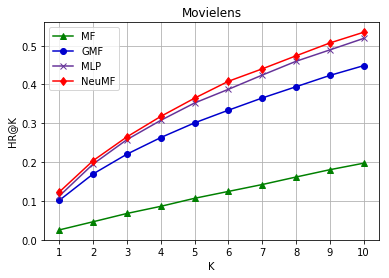

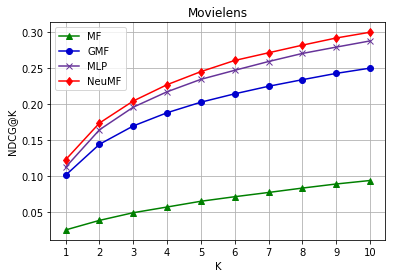

In [20]:
color_MF, color_GMF, color_MLP, color_NeuMF = "green", "mediumblue", "rebeccapurple", "red"
K_values = [i for i in range(1,maxK+1)]
path_to_save_figures = "Figures/"

plt.figure("K")
plt.plot(K_values, hits_MF, color=color_MF, marker="^")
plt.plot(K_values, hits_GMF, color=color_GMF, marker="o")
plt.plot(K_values, hits_MLP, color=color_MLP, marker="x")
plt.plot(K_values, hits_NeuMF, color=color_NeuMF, marker="d")
plt.xlabel("K")
plt.ylabel("HR@K")
plt.legend(("MF","GMF","MLP","NeuMF",))
plt.title("Movielens")
plt.xticks(K_values)
plt.grid()
plt.savefig(fname=path_to_save_figures+"experiment4_hr_movielens.png")

plt.figure("K2")
plt.plot(K_values, ndcgs_MF, color=color_MF, marker="^")
plt.plot(K_values, ndcgs_GMF, color=color_GMF, marker="o")
plt.plot(K_values, ndcgs_MLP, color=color_MLP, marker="x")
plt.plot(K_values, ndcgs_NeuMF, color=color_NeuMF, marker="d")
plt.xlabel("K")
plt.ylabel("NDCG@K")
plt.legend(("MF","GMF","MLP","NeuMF",))
plt.title("Movielens")
plt.xticks(K_values)
plt.grid()
plt.savefig(fname=path_to_save_figures+"experiment4_ndcg_movielens.png")

plt.show()

#### Dataset Pinterest

In [21]:
MF = get_model_MF(num_users=num_users_pinterest, num_items=num_items_pinterest, factors=8)
GMF = get_model_GMF(num_users=num_users_pinterest, num_items=num_items_pinterest, factors=8)
MLP = get_model_MLP(num_users=num_users_pinterest, num_items=num_items_pinterest, layers=[32,16,8])
NeuMF = get_model_NeuMF2(num_users=num_users_pinterest, num_items=num_items_pinterest, layers=[16,8,4])

print("Training of every model over 3 epochs...\n")

MF.fit(x=train_features_pinterest, y=train_labels_pinterest, batch_size=batch_size, epochs=3, verbose=0, shuffle=True)
GMF.fit(x=train_features_pinterest, y=train_labels_pinterest, batch_size=batch_size, epochs=3, verbose=0, shuffle=True)
MLP.fit(x=train_features_pinterest, y=train_labels_pinterest, batch_size=batch_size, epochs=3, verbose=0, shuffle=True)
NeuMF.fit(x=train_features_pinterest, y=train_labels_pinterest, batch_size=batch_size, epochs=3, verbose=0, shuffle=True)

maxK = 10
hits, ndcgs = [], []

start = time()

for K in range(1, maxK+1):
    print("Evaluation of Top-K item recommendation for K={:.0f}".format(K))
    hit, ndcg = evaluate_models(models=[MF, GMF, MLP, NeuMF], test_set=test_set_pinterest, K=K)
    hits.append(hit)
    ndcgs.append(ndcg)

hits, ndcgs = np.array(hits), np.array(ndcgs)

hits_MF, hits_GMF, hits_MLP, hits_NeuMF = hits[:,0], hits[:,1], hits[:,2], hits[:,3]
ndcgs_MF, ndcgs_GMF, ndcgs_MLP, ndcgs_NeuMF = ndcgs[:,0], ndcgs[:,1], ndcgs[:,2], ndcgs[:,3]

run_time = time()-start
print("\nRunning time : {:.0f} min {:.0f} sec".format(run_time//60, run_time%60))

Training of every model over 3 epochs...

Evaluation of Top-K item recommendation for K=1
Evaluation of Top-K item recommendation for K=2
Evaluation of Top-K item recommendation for K=3
Evaluation of Top-K item recommendation for K=4
Evaluation of Top-K item recommendation for K=5
Evaluation of Top-K item recommendation for K=6
Evaluation of Top-K item recommendation for K=7
Evaluation of Top-K item recommendation for K=8
Evaluation of Top-K item recommendation for K=9
Evaluation of Top-K item recommendation for K=10

Running time : 4 min 58 sec


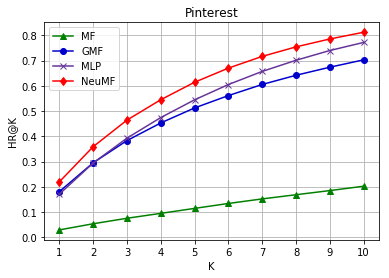

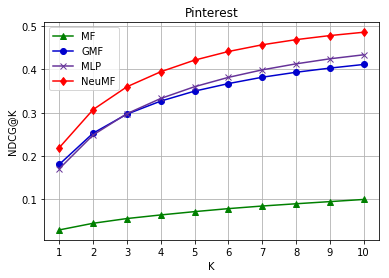

In [24]:
color_MF, color_GMF, color_MLP, color_NeuMF = "green", "mediumblue", "rebeccapurple", "red"
K_values = [i for i in range(1,maxK+1)]
path_to_save_figures = "Figures/"

plt.figure("K")
plt.plot(K_values, hits_MF, color=color_MF, marker="^")
plt.plot(K_values, hits_GMF, color=color_GMF, marker="o")
plt.plot(K_values, hits_MLP, color=color_MLP, marker="x")
plt.plot(K_values, hits_NeuMF, color=color_NeuMF, marker="d")
plt.xlabel("K")
plt.ylabel("HR@K")
plt.legend(("MF","GMF","MLP","NeuMF",))
plt.title("Pinterest")
plt.xticks(K_values)
plt.grid()
plt.savefig(fname=path_to_save_figures+"experiment4_hr_pinterest.png")

plt.figure("K2")
plt.plot(K_values, ndcgs_MF, color=color_MF, marker="^")
plt.plot(K_values, ndcgs_GMF, color=color_GMF, marker="o")
plt.plot(K_values, ndcgs_MLP, color=color_MLP, marker="x")
plt.plot(K_values, ndcgs_NeuMF, color=color_NeuMF, marker="d")
plt.xlabel("K")
plt.ylabel("NDCG@K")
plt.legend(("MF","GMF","MLP","NeuMF",))
plt.title("Pinterest")
plt.xticks(K_values)
plt.grid()
plt.savefig(fname=path_to_save_figures+"experiment4_ndcg_pinterest.png")

plt.show()

### Expérience 5 : L'architecture du MLP

Ici nous allons faire varier le nombre de couches et le nombre de neurones par couches dans le MLP.

#### Dataset MovieLens

In [103]:
start = time()

Factors = [8,16,32,64]
hits, ndcgs = [], []
max_num_hidden_layers = 4

for num_hidden_layers in range(max_num_hidden_layers+1):
    print()
    print("Number of hidden layers:", num_hidden_layers)
    models_MLP = []
    for factors in Factors:
        print("Number of predictive factors : {}".format(factors))
        layers = []
        for i in range(num_hidden_layers):
            layers = [(2**i)*factors] + layers
        print("layers:", layers)
        MLP = get_model_MLP(num_users=num_users_movielens, num_items=num_items_movielens, layers=layers, d=int(factors/2))
        MLP.fit(x=train_features_movielens, y=train_labels_movielens, epochs=3, batch_size=batch_size, shuffle=True, verbose=0)
        models_MLP.append(MLP)
    hits_hidden_layers, ndcgs_hidden_layers = evaluate_models(models=models_MLP, test_set=test_set_movielens, K=K)
    hits.append(hits_hidden_layers)
    ndcgs.append(ndcgs_hidden_layers)
    #print(hits, ndcgs)

hits, ndcgs = np.transpose(np.array(hits)), np.transpose(np.array(ndcgs))

print("\nHits:")
print(hits)
print("\nNDCGs")
print(ndcgs)

run_time = time()-start
print("\nRunning time : {:.0f} min {:.0f} sec".format(run_time//60, run_time%60))


Number of hidden layers: 0
Number of predictive factors : 8
layers: []
Number of predictive factors : 16
layers: []
Number of predictive factors : 32
layers: []
Number of predictive factors : 64
layers: []

Number of hidden layers: 1
Number of predictive factors : 8
layers: [8]
Number of predictive factors : 16
layers: [16]
Number of predictive factors : 32
layers: [32]
Number of predictive factors : 64
layers: [64]

Number of hidden layers: 2
Number of predictive factors : 8
layers: [16, 8]
Number of predictive factors : 16
layers: [32, 16]
Number of predictive factors : 32
layers: [64, 32]
Number of predictive factors : 64
layers: [128, 64]

Number of hidden layers: 3
Number of predictive factors : 8
layers: [32, 16, 8]
Number of predictive factors : 16
layers: [64, 32, 16]
Number of predictive factors : 32
layers: [128, 64, 32]
Number of predictive factors : 64
layers: [256, 128, 64]

Number of hidden layers: 4
Number of predictive factors : 8
layers: [64, 32, 16, 8]
Number of pred

In [106]:
print(hits)
print()
print(ndcgs)

[[0.45082781 0.44884106 0.46456954 0.50529801 0.57798013]
 [0.44850993 0.44337748 0.5115894  0.5647351  0.6057947 ]
 [0.44817881 0.45248344 0.53874172 0.61175497 0.63278146]
 [0.45066225 0.48211921 0.60066225 0.6294702  0.63857616]]

[[0.25109803 0.25120871 0.25849781 0.27748145 0.32834381]
 [0.24979429 0.24952568 0.28474931 0.31517734 0.34542865]
 [0.24989728 0.25133927 0.30102807 0.35094815 0.36367556]
 [0.24890061 0.26721765 0.33767588 0.36092303 0.36738864]]


#### Dataset Pinterest

In [107]:
start = time()

Factors = [8,16,32,64]
hits, ndcgs = [], []
max_num_hidden_layers = 4

for num_hidden_layers in range(max_num_hidden_layers+1):
    print()
    print("Number of hidden layers:", num_hidden_layers)
    models_MLP = []
    for factors in Factors:
        print("Number of predictive factors : {}".format(factors))
        layers = []
        for i in range(num_hidden_layers):
            layers = [(2**i)*factors] + layers
        print("layers:", layers)
        MLP = get_model_MLP(num_users=num_users_pinterest, num_items=num_items_pinterest, layers=layers, d=int(factors/2))
        MLP.fit(x=train_features_pinterest, y=train_labels_pinterest, epochs=3, batch_size=batch_size, shuffle=True, verbose=0)
        models_MLP.append(MLP)
    hits_hidden_layers, ndcgs_hidden_layers = evaluate_models(models=models_MLP, test_set=test_set_pinterest, K=K)
    hits.append(hits_hidden_layers)
    ndcgs.append(ndcgs_hidden_layers)
    #print(hits, ndcgs)

hits, ndcgs = np.transpose(np.array(hits)), np.transpose(np.array(ndcgs))

print("\nHits:")
print(hits)
print("\nNDCGs")
print(ndcgs)

run_time = time()-start
print("\nRunning time : {:.0f} min {:.0f} sec".format(run_time//60, run_time%60))


Number of hidden layers: 0
Number of predictive factors : 8
layers: []
Number of predictive factors : 16
layers: []
Number of predictive factors : 32
layers: []
Number of predictive factors : 64
layers: []

Number of hidden layers: 1
Number of predictive factors : 8
layers: [8]
Number of predictive factors : 16
layers: [16]
Number of predictive factors : 32
layers: [32]
Number of predictive factors : 64
layers: [64]

Number of hidden layers: 2
Number of predictive factors : 8
layers: [16, 8]
Number of predictive factors : 16
layers: [32, 16]
Number of predictive factors : 32
layers: [64, 32]
Number of predictive factors : 64
layers: [128, 64]

Number of hidden layers: 3
Number of predictive factors : 8
layers: [32, 16, 8]
Number of predictive factors : 16
layers: [64, 32, 16]
Number of predictive factors : 32
layers: [128, 64, 32]
Number of predictive factors : 64
layers: [256, 128, 64]

Number of hidden layers: 4
Number of predictive factors : 8
layers: [64, 32, 16, 8]
Number of pred